# JP Morgan Virtual Inter Exp Porj Sep 2023

## Task 3: Credit Risk Analysis

**Aim**
Use the provided data to train a function that will estimate the probability of default for a borrower.

**Objectives**
1. Produce a function that can take in the properties of a loan and output the  expected loss.
2. Explore some technique including
> * Simple regression: -- Accuracy of the Logistic Regression model is:  0.99; Accuracy of Logisitic Regression model after replace variable is: 0.9979
> * XGBoost: -- Accuracy of the XGBoost is 0.9998
> * Random forest: -- Accuracy of the Random Forest model is 0.9997


3. Use multiple methods and provide a comparative analysis.

**Raw data info:**
- borrower
- income
- total loans outstanding
- Previsouly defaulted on a loan
- Assuming a recovery rate of 10%, this can be used to give the expected loss on a loan.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import sklearn as sk
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
url = 'https://raw.githubusercontent.com/LeiZhu315/JP_Morgan_Storage_Contract_Pricing_Proj/main/Task%203%20and%204_Loan_Data.csv'
df = pd.read_csv(url)
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


In [ ]:
df.describe()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.974577e+06,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700,0.185100
std,2.293890e+06,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906,0.388398
min,1.000324e+06,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,2.977661e+06,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000
50%,4.989502e+06,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000
75%,6.967210e+06,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000
max,8.999789e+06,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000,1.000000


## 1. Exploratory Data Analysis
### 1.1. Data Cleaning
#### 1.1.1. Missing Data
No missing data has been detected

In [ ]:
df.isnull().sum()/len(df) * 100

customer_id                 0.0
credit_lines_outstanding    0.0
loan_amt_outstanding        0.0
total_debt_outstanding      0.0
income                      0.0
years_employed              0.0
fico_score                  0.0
default                     0.0
dtype: float64

#### 1.1.2. Duplicated Data
No duplicated data deteced

In [ ]:
dd = df.duplicated()
print(dd.sum())

0


#### 1.1.3. Outlier Data

Firstly we look at the distributions of the data

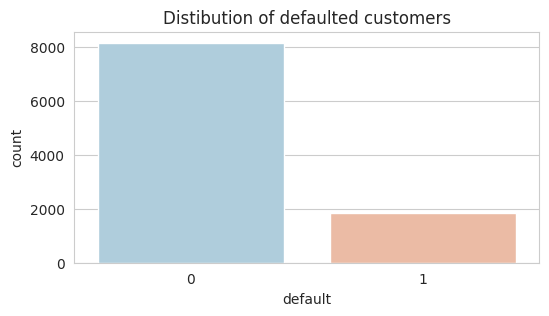

In [ ]:
sns.set_style('whitegrid')
fig, ax1 = plt.subplots(figsize=(6, 3))
sns.countplot(x='default', data=df, palette='RdBu_r').set(title='Distibution of defaulted customers')
plt.show()
# The ratio between non-default and default customers is highly biased

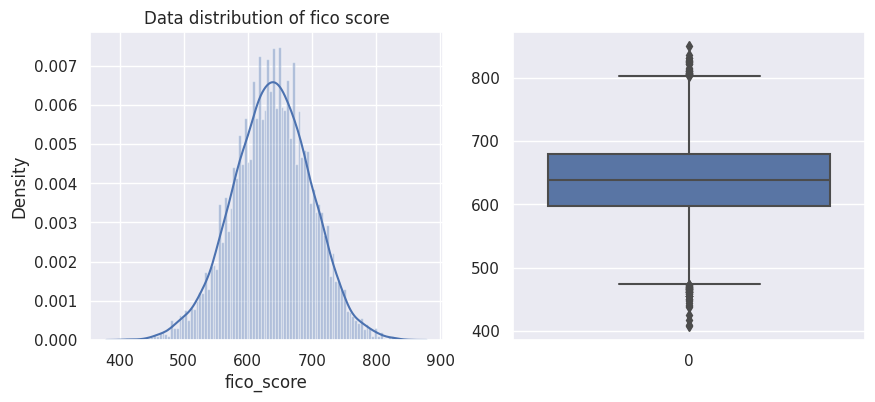

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
sns.distplot(df['fico_score'], ax=ax[0], kde=True, bins=100).set(title='Data distribution of fico score')
sns.boxplot(df['fico_score'], ax=ax[1])
plt.show()

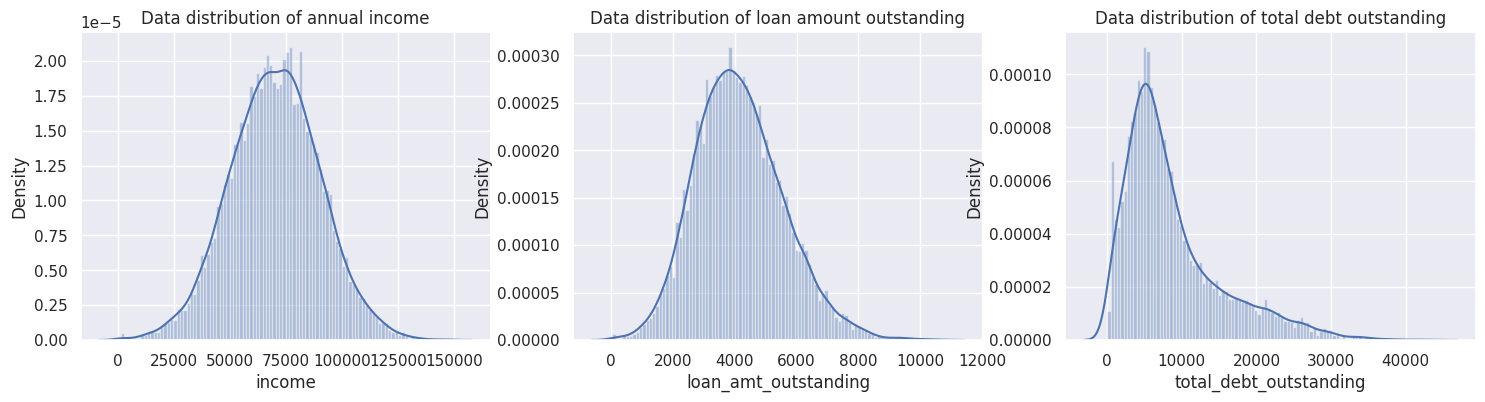

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 4))
sns.distplot(df['income'], ax=ax[0], kde=True, bins=100).set(title='Data distribution of annual income')
sns.distplot(df['loan_amt_outstanding'], ax=ax[1], kde=True, bins=100).set(title='Data distribution of loan amount outstanding')
sns.distplot(df['total_debt_outstanding'], ax=ax[2], kde=True, bins=100).set(title='Data distribution of total debt outstanding')
plt.show()
# The distributions of annula income and amount outstanding are close to normal distirbution, however, the distribution of debt outstanding is skewed.

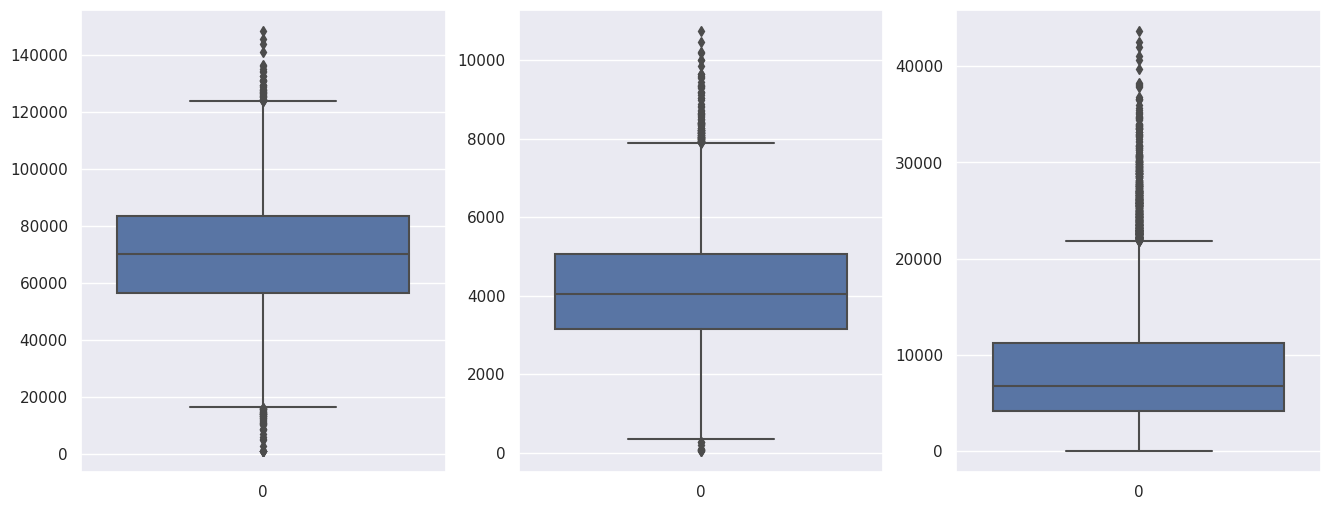

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(16, 6))
sns.boxplot(df['income'], ax=ax[0])
sns.boxplot(df['loan_amt_outstanding'], ax=ax[1])
sns.boxplot(df['total_debt_outstanding'], ax=ax[2])
plt.show()

In [ ]:
from matplotlib.cbook import boxplot_stats
df_clean = df.copy()
outliers = [y for stat in boxplot_stats(df_clean['total_debt_outstanding']) for y in stat['fliers']]
print('Outlier percentage: %.2f %%' % (len(outliers) / len(df_clean) * 100))

Outlier percentage: 6.02 %


In [ ]:
outliers = [y for stat in boxplot_stats(df_clean['income']) for y in stat['fliers']]
print('Outlier percentage: %.2f %%' % (len(outliers) / len(df_clean) * 100))

Outlier percentage: 0.86 %


In [ ]:
outliers = [y for stat in boxplot_stats(df_clean['loan_amt_outstanding']) for y in stat['fliers']]
print('Outlier percentage: %.2f %%' % (len(outliers) / len(df_clean) * 100))

Outlier percentage: 1.15 %


In [ ]:
Q1 = df_clean.quantile(0.25)
Q3 = df_clean.quantile(0.75)
IQR = Q3 - Q1
outlier_step = 1.5 * IQR
df_clean = df_clean[~((df_clean['income'] < (Q1['income'] - 1.5 * IQR['income'])) | df_clean['income'] > (Q3['income'] + 1.5 * IQR['income']))]
df_clean = df_clean[~((df_clean['loan_amt_outstanding'] < (Q1['loan_amt_outstanding'] - 1.5 * IQR['loan_amt_outstanding'])) | df_clean['loan_amt_outstanding'] > (Q3['loan_amt_outstanding'] + 1.5 * IQR['loan_amt_outstanding']))]
df_clean = df_clean[~((df_clean['total_debt_outstanding'] < (Q1['total_debt_outstanding'] - 1.5 * IQR['total_debt_outstanding'])) | df_clean['total_debt_outstanding'] > (Q3['total_debt_outstanding'] + 1.5 * IQR['total_debt_outstanding']))]
df_clean.shape
# We use IQR to filter outliers, and we detect no outliers.

(10000, 8)

Now lets look at distributions of descrete variables

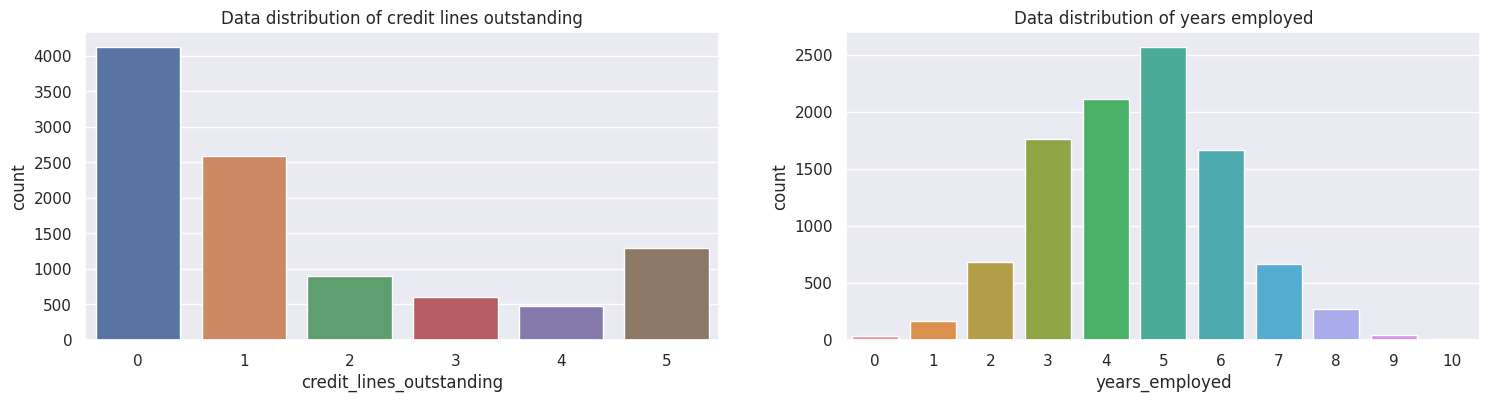

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 4))
sns.countplot(x = 'credit_lines_outstanding', data=df, ax=ax[0]).set(title='Data distribution of credit lines outstanding')
sns.countplot(x = 'years_employed', data=df, ax=ax[1]).set(title='Data distribution of years employed')
plt.show()

### 1.2. Dataset Exploring
Understand the relationship between independent variables and the dependent variable

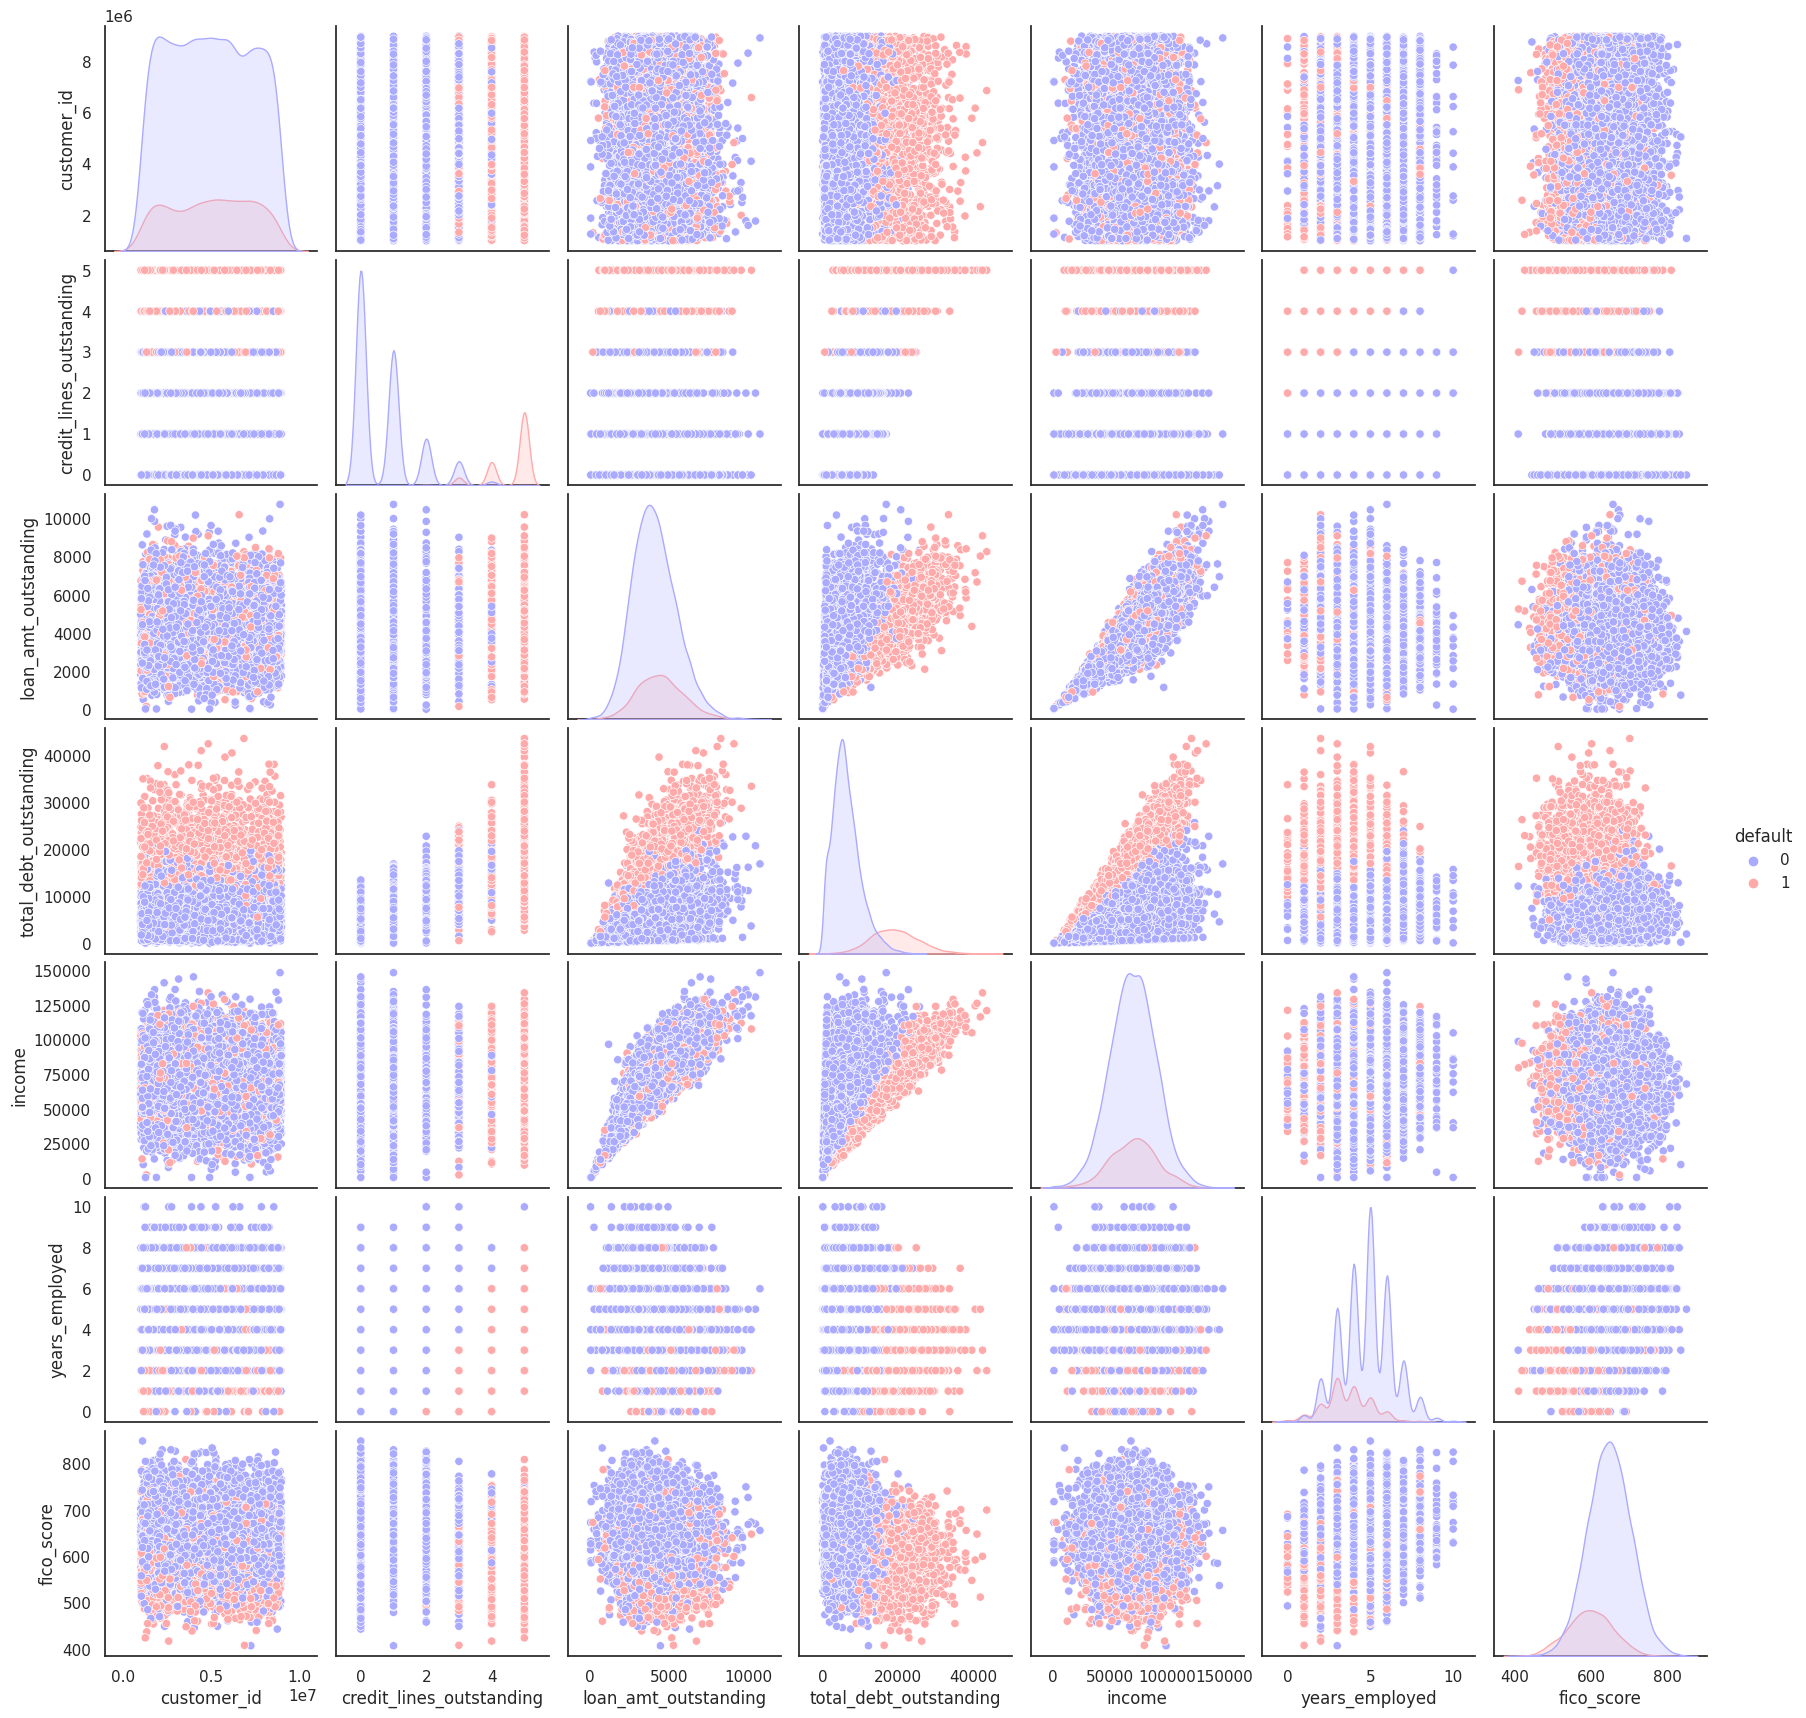

In [ ]:
sns.pairplot(data=df_clean, hue='default', palette='bwr')

In [ ]:
df_grouped = df.groupby([pd.cut(df['income'], np.arange(1, 1000.0+100000, 10000)), 'default']).size()
df_grouped1 = df_grouped.groupby(level=0).apply(lambda x: x / x.sum() * 100).unstack(level='default').reset_index()
df_grouped = df_grouped.groupby(level=0).apply(lambda x: x).unstack(level='default').reset_index()
df_grouped['Total'] = df_grouped[0] + df_grouped[1]
df_grouped

default,income,0,1,Total
0,"(1.0, 10001.0]",14,2,16
1,"(10001.0, 20001.0]",40,13,53
2,"(20001.0, 30001.0]",142,31,173
3,"(30001.0, 40001.0]",348,71,419
4,"(40001.0, 50001.0]",760,174,934
5,"(50001.0, 60001.0]",1226,257,1483
6,"(60001.0, 70001.0]",1563,333,1896
7,"(70001.0, 80001.0]",1548,364,1912
8,"(80001.0, 90001.0]",1234,303,1537
9,"(90001.0, 100001.0]",769,153,922


In [ ]:
df_grouped1

default,income,0,1
0,"(1.0, 10001.0]",87.500000,12.500000
1,"(10001.0, 20001.0]",75.471698,24.528302
2,"(20001.0, 30001.0]",82.080925,17.919075
3,"(30001.0, 40001.0]",83.054893,16.945107
4,"(40001.0, 50001.0]",81.370450,18.629550
5,"(50001.0, 60001.0]",82.670263,17.329737
6,"(60001.0, 70001.0]",82.436709,17.563291
7,"(70001.0, 80001.0]",80.962343,19.037657
8,"(80001.0, 90001.0]",80.286272,19.713728
9,"(90001.0, 100001.0]",83.405640,16.594360


[Text(0, 0, '(1.0, 10001.0]'),
 Text(1, 0, '(10001.0, 20001.0]'),
 Text(2, 0, '(20001.0, 30001.0]'),
 Text(3, 0, '(30001.0, 40001.0]'),
 Text(4, 0, '(40001.0, 50001.0]'),
 Text(5, 0, '(50001.0, 60001.0]'),
 Text(6, 0, '(60001.0, 70001.0]'),
 Text(7, 0, '(70001.0, 80001.0]'),
 Text(8, 0, '(80001.0, 90001.0]'),
 Text(9, 0, '(90001.0, 100001.0]')]

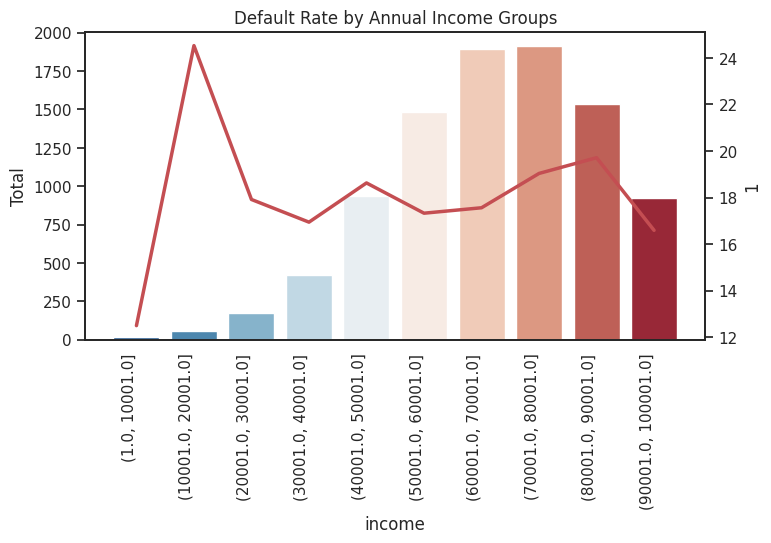

In [ ]:
sns.set_style('white')
df_grouped = df_grouped.dropna()
df_grouped1 = df_grouped1.dropna()
fig, ax1 = plt.subplots(figsize=(8, 4))
sns.barplot(data=df_grouped, x='income', y='Total', ax=ax1, palette='RdBu_r')
ax2 = ax1.twinx()
sns.lineplot(data=df_grouped1, x=df_grouped1['income'].astype(str), y=df_grouped1[1], ax=ax2, color='r', linewidth=2.5).set(title='Default Rate by Annual Income Groups')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, horizontalalignment='right')

In [ ]:
df_grouped = df.groupby([pd.cut(df['loan_amt_outstanding'], np.arange(1, 1000.0+10000, 1000)), 'default']).size()
df_grouped1 = df_grouped.groupby(level=0).apply(lambda x: x / x.sum() * 100).unstack(level='default').reset_index()
df_grouped = df_grouped.groupby(level=0).apply(lambda x: x).unstack(level='default').reset_index()
df_grouped['Total'] = df_grouped[0] + df_grouped[1]

[Text(0, 0, '(1.0, 1001.0]'),
 Text(1, 0, '(1001.0, 2001.0]'),
 Text(2, 0, '(2001.0, 3001.0]'),
 Text(3, 0, '(3001.0, 4001.0]'),
 Text(4, 0, '(4001.0, 5001.0]'),
 Text(5, 0, '(5001.0, 6001.0]'),
 Text(6, 0, '(6001.0, 7001.0]'),
 Text(7, 0, '(7001.0, 8001.0]'),
 Text(8, 0, '(8001.0, 9001.0]'),
 Text(9, 0, '(9001.0, 10001.0]')]

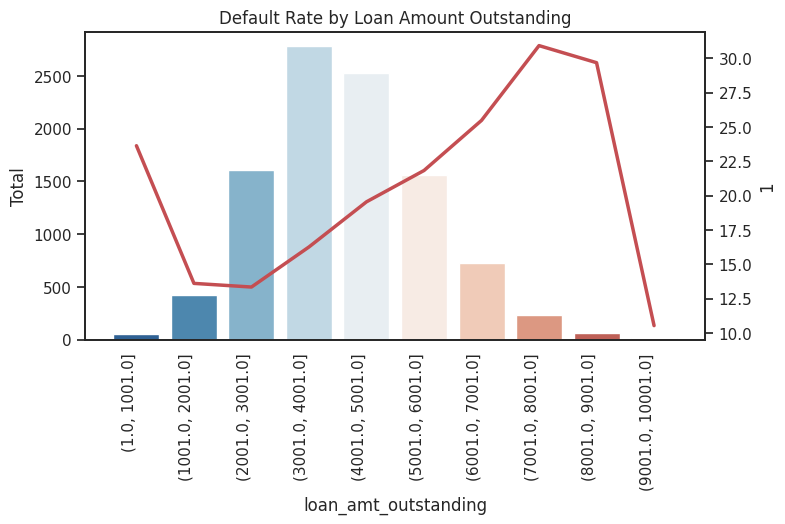

In [ ]:
sns.set_style('white')
df_grouped = df_grouped.dropna()
df_grouped1 = df_grouped1.dropna()
fig, ax1 = plt.subplots(figsize=(8, 4))
sns.barplot(data=df_grouped, x='loan_amt_outstanding', y='Total', ax=ax1, palette='RdBu_r')
ax2 = ax1.twinx()
sns.lineplot(data=df_grouped1, x=df_grouped1['loan_amt_outstanding'].astype(str), y=df_grouped1[1], ax=ax2, color='r', linewidth=2.5).set(title='Default Rate by Loan Amount Outstanding')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, horizontalalignment='right')

In [ ]:
df_grouped = df.groupby([pd.cut(df['total_debt_outstanding'], np.arange(1, 1000.0+40000, 5000)), 'default']).size()
df_grouped1 = df_grouped.groupby(level=0).apply(lambda x: x / x.sum() * 100).unstack(level='default').reset_index()
df_grouped = df_grouped.groupby(level=0).apply(lambda x: x).unstack(level='default').reset_index()
df_grouped['Total'] = df_grouped[0] + df_grouped[1]

[Text(0, 0, '(1.0, 5001.0]'),
 Text(1, 0, '(5001.0, 10001.0]'),
 Text(2, 0, '(10001.0, 15001.0]'),
 Text(3, 0, '(15001.0, 20001.0]'),
 Text(4, 0, '(20001.0, 25001.0]'),
 Text(5, 0, '(25001.0, 30001.0]'),
 Text(6, 0, '(30001.0, 35001.0]'),
 Text(7, 0, '(35001.0, 40001.0]')]

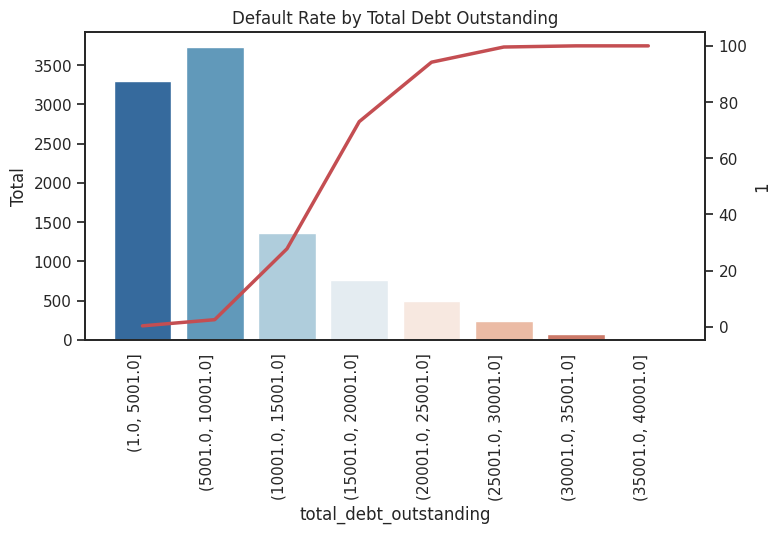

In [ ]:
sns.set_style('white')
df_grouped = df_grouped.dropna()
df_grouped1 = df_grouped1.dropna()
fig, ax1 = plt.subplots(figsize=(8, 4))
sns.barplot(data=df_grouped, x='total_debt_outstanding', y='Total', ax=ax1, palette='RdBu_r')
ax2 = ax1.twinx()
sns.lineplot(data=df_grouped1, x=df_grouped1['total_debt_outstanding'].astype(str), y=df_grouped1[1], ax=ax2, color='r', linewidth=2.5).set(title='Default Rate by Total Debt Outstanding')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, horizontalalignment='right')

In [ ]:
df_grouped = df.groupby([pd.cut(df['fico_score'], np.arange(400, 50.0+850, 50)), 'default']).size()
df_grouped1 = df_grouped.groupby(level=0).apply(lambda x: x / x.sum() * 100).unstack(level='default').reset_index()
df_grouped = df_grouped.groupby(level=0).apply(lambda x: x).unstack(level='default').reset_index()
df_grouped['Total'] = df_grouped[0] + df_grouped[1]

[Text(0, 0, '(400.0, 450.0]'),
 Text(1, 0, '(450.0, 500.0]'),
 Text(2, 0, '(500.0, 550.0]'),
 Text(3, 0, '(550.0, 600.0]'),
 Text(4, 0, '(600.0, 650.0]'),
 Text(5, 0, '(650.0, 700.0]'),
 Text(6, 0, '(700.0, 750.0]'),
 Text(7, 0, '(750.0, 800.0]'),
 Text(8, 0, '(800.0, 850.0]')]

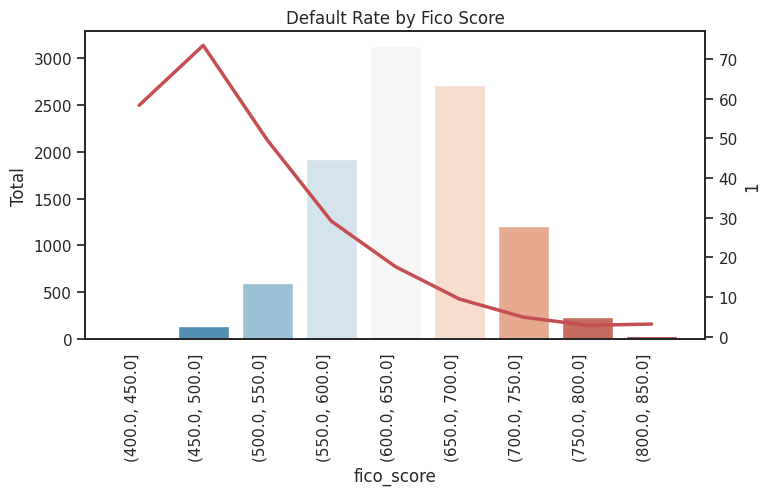

In [ ]:
sns.set_style('white')
df_grouped = df_grouped.dropna()
df_grouped1 = df_grouped1.dropna()
fig, ax1 = plt.subplots(figsize=(8, 4))
sns.barplot(data=df_grouped, x='fico_score', y='Total', ax=ax1, palette='RdBu_r')
ax2 = ax1.twinx()
sns.lineplot(data=df_grouped1, x=df_grouped1['fico_score'].astype(str), y=df_grouped1[1], ax=ax2, color='r', linewidth=2.5).set(title='Default Rate by Fico Score')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, horizontalalignment='right')

In [ ]:
df_grouped = df.groupby(['years_employed', 'default']).size()
df_grouped1 = df_grouped.groupby(level=0).apply(lambda x: x / x.sum() * 100).unstack(level='default').reset_index()
df_grouped = df_grouped.groupby(level=0).apply(lambda x: x).unstack(level='default').reset_index()
df_grouped['Total'] = df_grouped[0] + df_grouped[1]
# df_grouped['years_employed'] = pd.Categorical(df_grouped['years_employed'],
#                                               categories=['< 1 year', '1 year', '2 year',
#                                                           '3 year', '4 year', '5 year',
#                                                           '6 year', '7 year', '8 year',
#                                                           '9 year', '10+ year'],
#                                               ordered=True)
# df_grouped1['years_employed'] = pd.Categorical(df_grouped1['years_employed'],
#                                               categories=['< 1 year', '1 year', '2 year',
#                                                           '3 year', '4 year', '5 year',
#                                                           '6 year', '7 year', '8 year',
#                                                           '9 year', '10+ year'],
#                                                ordered=True)

[Text(0, 0, '0'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5'),
 Text(6, 0, '6'),
 Text(7, 0, '7'),
 Text(8, 0, '8')]

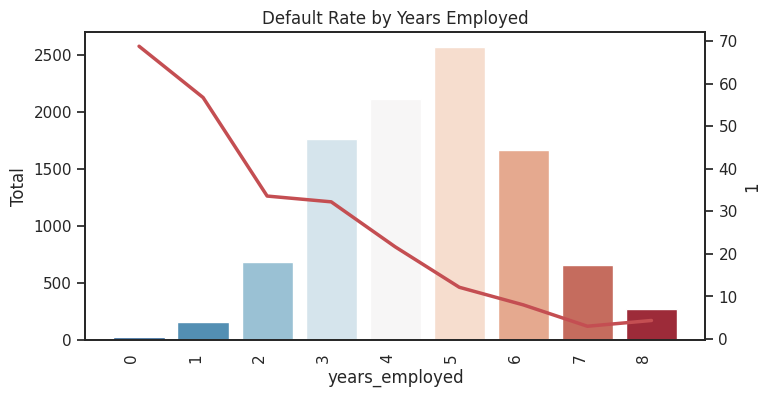

In [ ]:
sns.set_style('white')
df_grouped = df_grouped.dropna()
df_grouped1 = df_grouped1.dropna()
fig, ax1 = plt.subplots(figsize=(8, 4))
sns.barplot(data=df_grouped, x='years_employed', y='Total', ax=ax1, palette='RdBu_r')
ax2 = ax1.twinx()
sns.lineplot(data=df_grouped1, x=df_grouped1['years_employed'].astype(str), y=df_grouped1[1], ax=ax2, color='r', linewidth=2.5).set(title='Default Rate by Years Employed')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, horizontalalignment='right')

In [ ]:
df_grouped = df.groupby(['credit_lines_outstanding', 'default']).size()
df_grouped1 = df_grouped.groupby(level=0).apply(lambda x: x / x.sum() * 100).unstack(level='default').reset_index()
df_grouped = df_grouped.groupby(level=0).apply(lambda x: x).unstack(level='default').reset_index()
df_grouped['Total'] = df_grouped[0] + df_grouped[1]

[Text(0, 0, '2'), Text(1, 0, '3'), Text(2, 0, '4'), Text(3, 0, '5')]

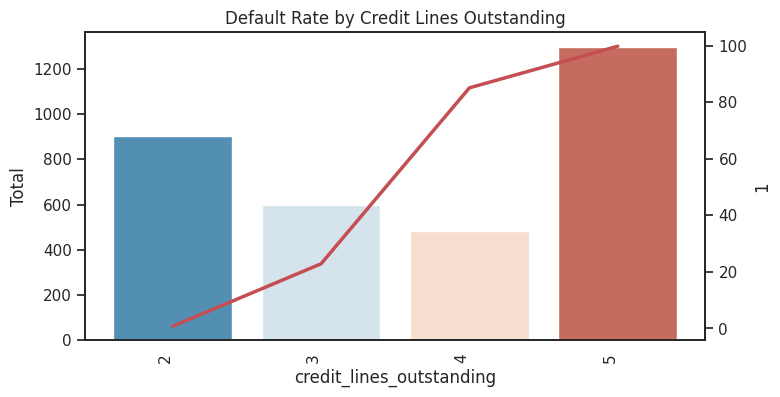

In [ ]:
sns.set_style('white')
df_grouped = df_grouped.dropna()
df_grouped1 = df_grouped1.dropna()
fig, ax1 = plt.subplots(figsize=(8, 4))
sns.barplot(data=df_grouped, x='credit_lines_outstanding', y='Total', ax=ax1, palette='RdBu_r')
ax2 = ax1.twinx()
sns.lineplot(data=df_grouped1, x=df_grouped1['credit_lines_outstanding'].astype(str), y=df_grouped1[1], ax=ax2, color='r', linewidth=2.5).set(title='Default Rate by Credit Lines Outstanding')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, horizontalalignment='right')

### 1.3. Feature Engineering

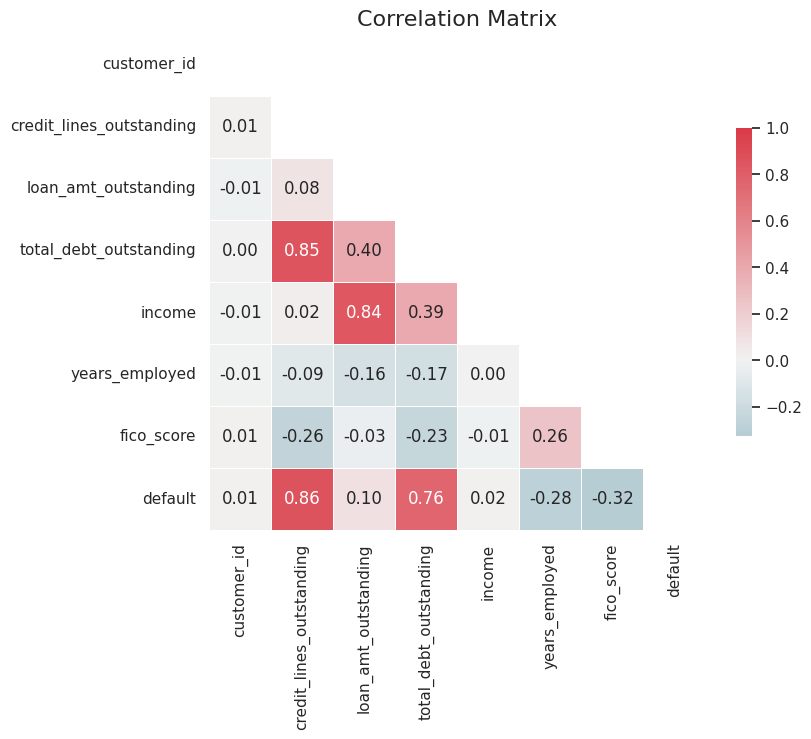

In [ ]:
sns.set(style='white')
corr = df_clean.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
fig, ax = plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=16)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, fmt='.2f', square=True,
            linewidths=.5, cbar_kws={'shrink': .5}, annot=True)
plt.show()

In [ ]:
df2 = df_clean.copy()
df2['loan_inc_ratio'] = df2['loan_amt_outstanding'] / df2['income']
df2['loan_inc_ratio'].max()

0.1021025195813301

In [ ]:
df_grouped=df2.groupby([pd.cut(df2['loan_inc_ratio'], np.arange(0, 0.02+0.1, 0.02)),'default']).size()
df_grouped1=df_grouped.groupby(level=0).apply(lambda x: x/x.sum() * 100).unstack(level='default').reset_index()
df_grouped=df_grouped.groupby(level=0).apply(lambda x: x).unstack(level='default').reset_index()
df_grouped['Total']=df_grouped[0] + df_grouped[1]

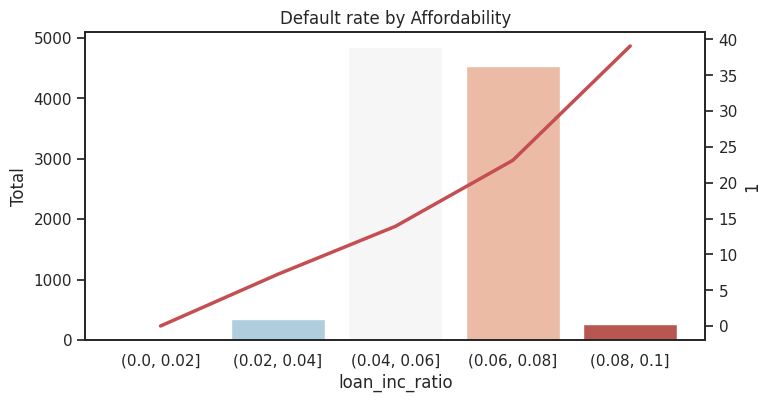

In [ ]:
df_grouped=df_grouped.dropna()
df_grouped1=df_grouped1.dropna()
fig, ax1 = plt.subplots(figsize=(8,4))
sns.set_style('white')
sns.barplot(data=df_grouped, x="loan_inc_ratio", y="Total", ax=ax1,palette='RdBu_r')
ax2 = ax1.twinx()
sns.lineplot(data=df_grouped1, x=df_grouped1["loan_inc_ratio"].astype(str), y=df_grouped1[1],ax=ax2, color='r', linewidth=2.5).set(title='Default rate by Affordability')
plt.show()

In [ ]:
df2['credict_line_debt_ratio'] = df2['credit_lines_outstanding'] * df2['total_debt_outstanding']
df2['credict_line_debt_ratio'].max()

218443.92049999998

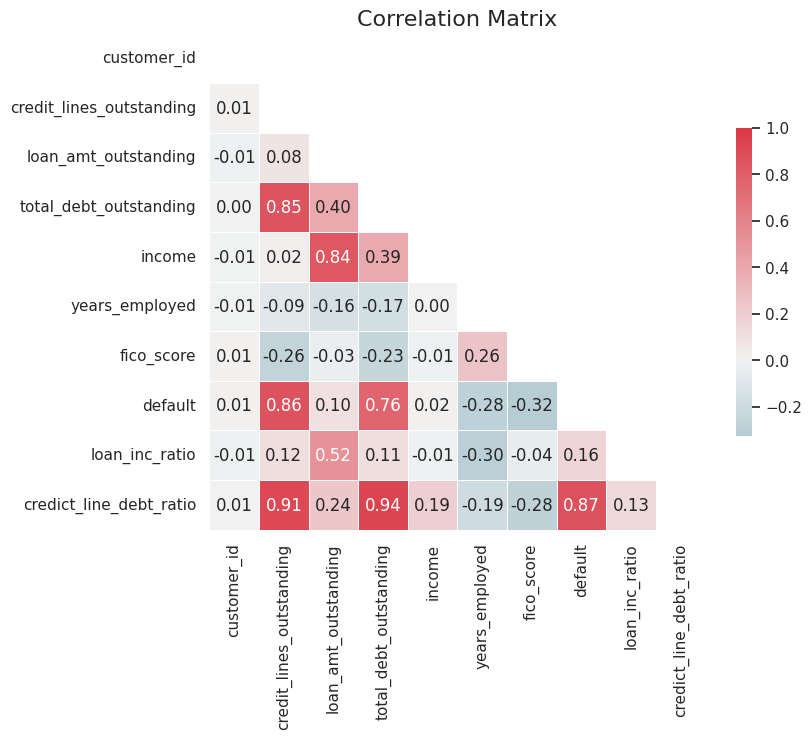

In [ ]:
sns.set(style='white')
corr = df2.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
fig, ax = plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=16)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, fmt='.2f', square=True,
            linewidths=.5, cbar_kws={'shrink': .5}, annot=True)
plt.show()

## 2. Predictive Modelling
### 2.1. Logistic regression

In [ ]:
data = df_clean.copy()
data['loan_inc_ratio'] = data['loan_amt_outstanding'] / data['income']

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
 8   loan_inc_ratio            10000 non-null  float64
dtypes: float64(4), int64(5)
memory usage: 781.2 KB


In [ ]:
train = data[['default', 'credit_lines_outstanding', 'total_debt_outstanding', 'years_employed', 'fico_score', 'loan_inc_ratio']]

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('default', axis=1),
                                                    train['default'], test_size=0.30,
                                                    stratify=train['default'],
                                                    random_state=11)

In [ ]:
logmodel = LogisticRegression(max_iter = 500)
logmodel.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [ ]:
predictions = logmodel.predict(X_test)
print(classification_report(y_test, predictions))
print('Accuracy Score: ', accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2445
           1       0.99      0.99      0.99       555

    accuracy                           1.00      3000
   macro avg       0.99      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

Accuracy Score:  0.997


<Axes: >

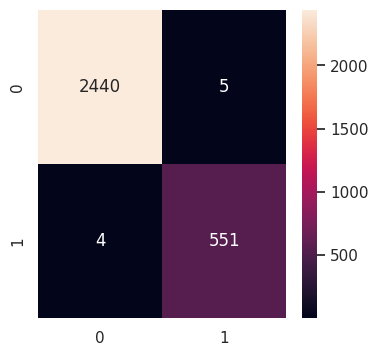

In [ ]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d')

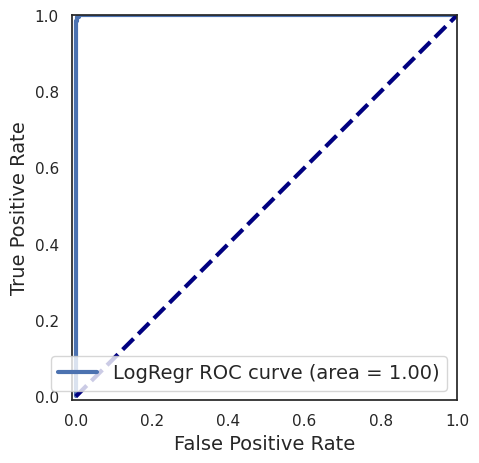

In [ ]:
y_predict_lr_prop = logmodel.predict_proba(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_predict_lr_prop[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(5, 5))
plt.axes().set_aspect('equal')
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.00])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

### 2.2. Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfmodel = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=42)
rfmodel.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, random_state=42)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2445
           1       0.99      0.99      0.99       555

    accuracy                           1.00      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       1.00      1.00      1.00      3000

Accuracy Score:  0.9953333333333333


<Axes: >

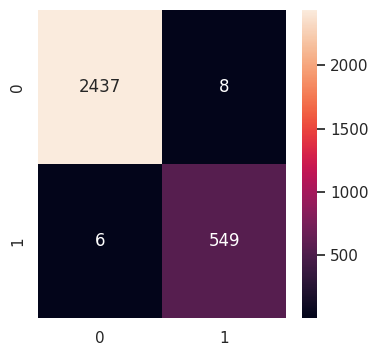

In [ ]:
predictions = rfmodel.predict(X_test)
print(classification_report(y_test, predictions))
print('Accuracy Score: ', accuracy_score(y_test, predictions))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d')

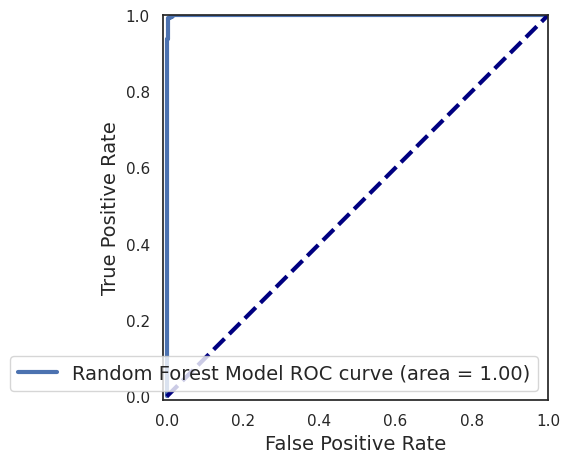

In [ ]:
y_predict_lr_prop = rfmodel.predict_proba(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_predict_lr_prop[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(5, 5))
plt.axes().set_aspect('equal')
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.00])
plt.plot(fpr_lr, tpr_lr, lw=3, label='Random Forest Model ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

### 2.3. XGboost Model

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgbmodel = XGBClassifier(random_state=42)
xgbmodel.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2445
           1       0.98      0.99      0.99       555

    accuracy                           1.00      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       1.00      1.00      1.00      3000

Accuracy Score:  0.9953333333333333


<Axes: >

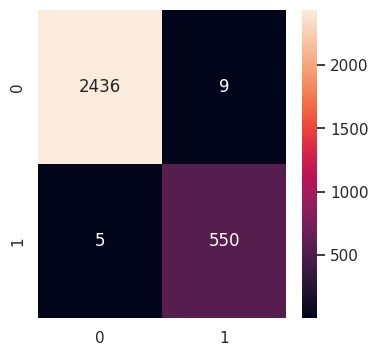

In [ ]:
predictions = xgbmodel.predict(X_test)
print(classification_report(y_test, predictions))
print('Accuracy Score: ', accuracy_score(y_test, predictions))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d')

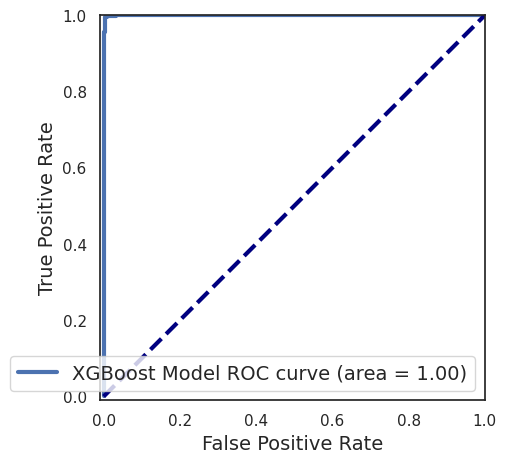

In [ ]:
y_predict_lr_prop = xgbmodel.predict_proba(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_predict_lr_prop[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(5, 5))
plt.axes().set_aspect('equal')
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.00])
plt.plot(fpr_lr, tpr_lr, lw=3, label='XGBoost Model ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

# Task 4

Charlie wants to build a **machine learning model** that will predict the probability of default, but while you are discussing the methodology, she mentions that the architecture she is using requires `*categorical data*`. As FICO ratings can take integer values in a large range, they will need to be mapped into `*buckets*`.

**Defination**

> FICO (Fair Isaac Corportation)

> Founders: Bill Fair/ Earl Isaac

A FICO score is a standardized credit score created by the Fair Isaac Corporation (FICO) that quantifies the creditworthiness of a borrower to a value between 300 to 850, based on various factors.

FICO scores are used in 90% of mortgage application decisions in the United States.

**Task**

The risk manager provides you with FICO scores for the borrowers in the bank’s portfolio and wants you to **construct a technique for predicting the PD (probability of default)** for the borrowers using these scores.

- **Aim**
> - Create a rating map that maps the FICO score of the borrowers to a rating where a lower rating signifies a better credit score.
> - You could consider many ways of solving the problem by optimizing different properties of the resulting buckets, such as the mean squared error or log-likelihood

* The process of doing this is known as quantization.

* The simplest way to quantize a signal is to choose the digital amplitude value closest to the original analog amplitude. This example shows the original analog signal (green), the quantized signal (black dots), the signal reconstructed from the quantized signal (yellow) and the difference between the original signal and the reconstructed signal (red). The difference between the original signal and the reconstructed signal is the quantization error and, in this simple quantization scheme, is a deterministic function of the input signal.

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics  import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
url = 'https://raw.githubusercontent.com/Hongyan-Wang/JP_Morgan_Project/main/Task_3_4_Loan_Data.csv'
df = pd.read_csv(url)
df.describe()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.974577e+06,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700,0.185100
std,2.293890e+06,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906,0.388398
min,1.000324e+06,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,2.977661e+06,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000
50%,4.989502e+06,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000
75%,6.967210e+06,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000
max,8.999789e+06,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000,1.000000


# Method 1: Maximum likelihood estimation

- 1. Reads in a CSV file using Pandas. It then creates two lists, x and y, that correspond to the 'observation' and 'rank' columns in the data, respectively.
- 2.  The log-likelihood function is defined to calculate the probability of observing the data given the parameter values.
- 3. The code then initializes a three-dimensional array, dp, that is used to store the calculated log-likelihood values for different sets of observations.
>  a. The first dimension represents the number of iterations performed|
>  b. the second dimension represents the rank of the observation |
>  c. The third dimension represents the log-likelihood and the index of the previous observation.

- 4. The code calculates the log-likelihood for the given data set by using the dp array. It then prints the results and outputs the indices of the observations that were used in the calculation.

## Result:
- 1. log likelyhood: -4217.8245
- 2. results: [850, 753, 752, 732, 696, 649, 611, 580, 552, 520, 300]


In [ ]:
x = df['default'].to_list()
y = df['fico_score'].to_list()
n = len(x)
print (len(x), len(y))

default = [0 for i in range(851)]
total = [0 for i in range(851)]

for i in range(n):
    y[i] = int(y[i])
    default[y[i]-300] += x[i]
    total[y[i]-300] += 1

for i in range(0, 551):
    default[i] += default[i-1]
    total[i] += total[i-1]

import numpy as np

def log_likelihood(n, k):
    p = k/n
    if (p==0 or p==1):
        return 0
    return k*np.log(p)+ (n-k)*np.log(1-p)


r = 10
dp = [[[-10**18, 0] for i in range(551)] for j in range(r+1)]

for i in range(r+1):
    for j in range(551):
        if (i==0):
            dp[i][j][0] = 0
        else:
            for k in range(j):
                if (total[j]==total[k]):
                    continue
                if (i==1):
                    dp[i][j][0] = log_likelihood(total[j], default[j])
                else:
                    if (dp[i][j][0] < (dp[i-1][k][0] + log_likelihood(total[j]-total[k], default[j] - default[k]))):
                        dp[i][j][0] = log_likelihood(total[j]-total[k], default[j]-default[k]) + dp[i-1][k][0]
                        dp[i][j][1] = k

print (round(dp[r][550][0], 4))

k = 550
l = []
while r >= 0:
    l.append(k+300)
    k = dp[r][k][1]
    r -= 1
print(l)

10000 10000
-4217.8245
[850, 753, 752, 732, 696, 649, 611, 580, 552, 520, 300]


# Method 2: Using genetic algorithm to optimise


 ## Result:
- 1. log likelyhood: -4243.0575
- 2. results: [850, 765, 729, 715, 696, 637, 608, 552, 541, 510, 300]

In [ ]:
df_FICO = df[['fico_score', 'default']]
df_FICO.describe()

,fico_score,default
count,10000.000000,10000.000000
mean,637.557700,0.185100
std,60.657906,0.388398
min,408.000000,0.000000
25%,597.000000,0.000000
50%,638.000000,0.000000
75%,679.000000,0.000000
max,850.000000,1.000000


In [ ]:
pip install geneticalgorithm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 950.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15080 sha256=c13bc7faa23ab4ad8e7852ae1fa9bc67ef5e898bb80b791cea246baf7bbab96e
  Stored in directory: /root/.cache/pip/wheels/3f/83/19/b5552bb9630e353f7c5b15be44bf10900afe1abbbfcf536afd
Successfully built func-timeout


In [ ]:
from geneticalgorithm import geneticalgorithm as ga

 The best solution found:
 [782. 462. 470. 510. 554. 580. 611. 651. 719.]

 Objective function:
 4231.70879820984


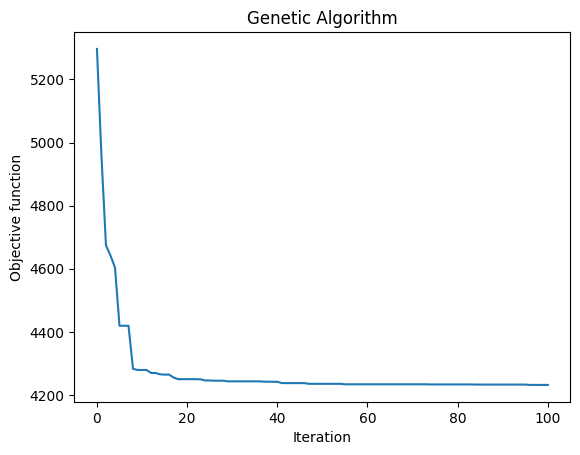

In [ ]:
def f(d):
  LL = 0
  for i in range(len(d)):
    if i == 0:
      l, u = 400, d[i+1]
    elif i == len(d) - 1:
      l, u = d[i], 850
    else:
      l, u = d[i], d[i+1]
    k = df_FICO.query(f'{l} < fico_score <= {u}')['default'].sum()
    n = df_FICO.query(f'{l} < fico_score <= {u}')['default'].shape[0]
    p = k / n if n != 0 else 0
    p = max(0.01, p)
    LL += k * np.log(p) + (n - k) * np.log(1 - p)
  return -1 * LL

n = 9
varbound = np.array([[400, 850]] * n)
model = ga(function=f, dimension=n, variable_type='int', variable_boundaries=varbound,
           algorithm_parameters = {'max_num_iteration':100, 'population_size': 100,
                                   'mutation_probability': 0.1,'elit_ratio': 0.01,
                                   'crossover_probability': 0.5,'parents_portion': 0.3,
                                   'crossover_type': 'uniform','max_iteration_without_improv': None},
           convergence_curve=True, progress_bar=True)
model.run()